## Using FAST.AI for NLP

Exploring the MIMIC III data set medical notes.

Tried working with the full dataset, but almost every training step takes many hours (~13 for initial training), predicted 14+ per epoch for fine tuning.

Instead will try to work with just 10% sample... Not sure that will work though

A few notes:
* See https://docs.fast.ai/text.transform.html#Tokenizer for details on what various artificial tokens (e.g xxup, xxmaj, etc.) mean
* Due to a change in the markdown package private API, the 'doc' functionality (e.g. ` doc(learn.lr_find)`) is currently broken. See https://github.com/fastai/fastai/commit/21faa5d187b2cccf2a48315d183c2863ed2cdc50

In [4]:
from fastai.text import *
from sklearn.model_selection import train_test_split

In [5]:
# run this to see what has already been imported
#whos

In [6]:
# pandas doesn't understand ~, so provide full path
base_path = Path('/home/jupyter/mimic')

In [7]:
# run this the first time to covert CSV to Pickle file
df = pd.read_csv(base_path/'NOTEEVENTS.csv', low_memory=False, memory_map=True)
df.to_pickle(base_path/'noteevents.pickle')

In [8]:
filename = base_path/'noteevents.pickle'

if os.path.isfile(filename):
    # this is much faster than reading a csv
    orig_df = pd.read_pickle(filename)
else:
    print('Could not find noteevent pickle file; creating it')
    # run this the first time to covert CSV to Pickle file
    orig_df = pd.read_csv(base_path/'NOTEEVENTS.csv', low_memory=False, memory_map=True)
    orig_df.to_pickle(filename)

In [9]:
df = orig_df.sample(frac=0.1)

In [10]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
2044605,2074653,31597,131426.0,2199-07-03,2199-07-03 17:15:00,2199-07-03 17:28:00,Nursing/other,Report,15819.0,NaN,NPN [**6-/2092**]\n\n\n\n #1. rec [**Month/Yea...
1415322,1434629,13177,131846.0,2126-11-18,2126-11-18 05:45:00,2126-11-18 06:04:00,Nursing/other,Report,19963.0,NaN,"NEURO: ORALLY INTUBATED, SEDATED ON PROPOFOL ..."
1232855,1238558,57190,NaN,2129-05-21,2129-05-21 11:42:00,NaN,Radiology,CHEST (PORTABLE AP),NaN,NaN,[**2129-5-21**] 11:42 AM\n CHEST (PORTABLE AP)...
1977557,1984153,22397,174403.0,2198-08-04,2198-08-04 14:31:00,2198-08-04 14:31:00,Nursing/other,Report,17894.0,NaN,6 Hyperbili\n\nREVISIONS TO PATHWAY:\n\n 6 Hy...
708926,711465,51909,186695.0,2184-10-30,2184-10-30 03:01:00,2184-10-30 06:41:28,Nursing,Nursing Progress Note,18804.0,NaN,"Aneurysm, other\n Assessment:\n Patient is..."


In [11]:
df.dtypes

ROW_ID           int64
SUBJECT_ID       int64
HADM_ID        float64
CHARTDATE       object
CHARTTIME       object
STORETIME       object
CATEGORY        object
DESCRIPTION     object
CGID           float64
ISERROR        float64
TEXT            object
dtype: object

In [12]:
df.shape

(208318, 11)

In [13]:
# split data into train and test sets
seed = 42
test_size = 0.333333333
train, test = train_test_split(df, test_size=test_size, random_state=seed)

In [14]:
train.shape

(138878, 11)

In [15]:
test.shape

(69440, 11)

In [16]:
# previously used 48; worked fine but never seemed to use even half of GPU memory
bs=64

Code to reload previously built language model

```python
filename = base_path/'mimic_lm.pickle'

if os.path.isfile(filename):
    data_lm = load_data(base_path, 'mimic_lm.pickle', bs=bs)
else:
    print('Couldnt find file')
```

Code to build initial version of language model

```python
```

In [13]:
## why does this only seem to use CPU?
# applies to both both textclasdatabunch and textlist...
# for 100% of the mimic noteevents data:
# run out of memory at 32 GB, error at 52 GB, trying 72GB now... got down to only 440MB free; if crash again, increase memory
# now at 20vCPU and 128GB RAM; ok up to 93%; got down to 22GB available
# succeeded with 20CPU and 128GB RAM...
# try smaller batch size? will that reduce memory requirements?
# with 10% dataset sample, it seems I could get by with perhaps 32GB system RAM
data_lm = (TextList.from_df(df, 'texts.csv', cols='TEXT')
           #We may have other temp folders that contain text files so we only keep what's in train and test
           .split_by_rand_pct(0.1)
           #We randomly split and keep 10% for validation
           .label_for_lm()
           #We want to do a language model so we label accordingly
           .databunch(bs=bs))

In [14]:
data_lm.save(base_path/'mimic_lm.pickle')

In [17]:
data_lm = load_data(base_path, 'mimic_lm.pickle', bs=bs)

If need to view more data, run appropriate line to make display wider/show more columns...
```python
# default 20
pd.get_option('display.max_columns')
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_columns', None) # show all
# default 50
pd.get_option('display.max_colwidth')
pd.set_option('display.max_colwidth', -1) # show all
```

In [18]:
data_lm.show_batch()
# how to look at original version of text
#df[df['TEXT'].str.contains('being paralyzed were discussed', case=False)].TEXT

idx,text
0,"stiff . xxmaj seems lethargic , sleeping through most of the morning , now more alert . \n \n xxup cv : xxmaj remains hemodynamically stable , tolerating norvasc w / xxup bp 100s-140s / 60s . xxup hr xxup nsr 60s-80s w / rare pvcs noted . xxmaj distal pulses palp , extremities warm / dry . \n \n xxup resp : breathing comfortably on trach collar"
1,". \n \n 2 . xxup sepsis : xxmaj infant remains in xxmaj ampicillin and xxmaj gentamicin . \n xxmaj antibiotics ordered to be d / c'ed at 48 hrs ( @ 1700 , [ * * 11 - 22 * * ] ) \n if blood cultures remain negative . xxmaj blood cultures negative \n to date . xxmaj plan : xxmaj continue to monitor"
2,"\n xxmaj glucose \n 126 \n 130 \n 52 \n 25 \n 195 \n 103 \n xxmaj other labs : xxup pt / xxup ptt / xxup inr:14.9 / 31.2 / 1.3 , xxmaj lactic xxmaj acid:1.0 mmol / l , \n xxmaj ca:8.2 mg / dl , xxmaj mg:2.3 mg / dl , xxup po4:3.3 mg / dl \n"
3,and xxmaj morphine \n xxmaj blood glucose monitored xxup q1h \n xxmaj turned per protocol \n xxmaj nitro titrated off \n xxmaj tolerating clear liquids \n xxmaj lytes monitored \n xxmaj time spent with pt to ensure realistic expectations for post - op pain \n management . xxmaj pt \n s expects to be completely painfree . xxmaj pt fall to sleep
4,"hr . feeds . xxmaj belly \n soft , void 4.2cc / kg , and had a sm . stool . xxmaj min . asp . and no \n spits . d - s 89 xxup k+ 5.6 xxmaj on kcl supps . \n # xxup 5o : xxmaj temp stable , active with cares . xxmaj music on this am . \n # xxup 6o"


In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


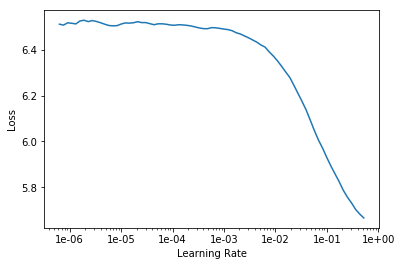

In [18]:
learn.recorder.plot(skip_end=15)

### Initial model training

Full data set took about 13 hours using the Nvidia P1000; Full data set was predicted to take about 25 hours with the T4

10% data is predicted to take about 1 hour (1:10) using the Nvidia P1000

In [20]:
# no idea how long nor how much resources this will take
# not sure 1e-2 is the right learning rate; maybe 1e-1 or between 1e-2 and 1e-1
# using t4
# progress bar says this will take around 24 hours... ran for about 52 minutes
# gpustat/nvidia-smi indicates currently only using about 5GB of GPU RAM
# using p100
# progress bar says this will take around 12 hours; took 13:16
# at start GPU using about 5GB RAM
# after about 8 hours GPU using about 7.5GB RAM.
# looks like I could increase batch size...
# with bs=64, still only seems to be using about 7GB GPU RAM after running for 15 minutes. will check after a bit, but likely can increase batch size further
learn.fit_one_cycle(1, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.725131,2.456228,0.537501,1:12:41


In [21]:
learn.save(base_path/'mimic_fit_head.pickle')

In [ ]:
learn.load(base_path/'mimic_fit_head.pickle')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 5e-3, moms=(0.8,0.7))

In [ ]:
learn.save(base_path/'mimic_fine_tuned.pickle')

In [ ]:
learn.load(base_path/'mimic_fine_tuned.pickle')

In [ ]:
# test the language generation capabilities of this model (not the point, but is interesting)
TEXT = "For confirmation, she underwent CTA of the lung which was negative for pulmonary embolism"
N_WORDS = 40
N_SENTENCES = 2
In [ ]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [ ]:
learn.save_encoder('mimic_fine_tuned_enc.pickle')